In [23]:
import harp
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
from sklearn.linear_model import LinearRegression

verbose = True

class Pulse:
    def __init__(self, signal: pd.DataFrame, approx_start: float, approx_end: float, registers: dict, margin: float = 1.5):
        self.register_dict = registers
        self.end = approx_end + margin
        self._slice_data(signal, approx_start, approx_end, margin)
        self._compute_region_metrics()
        self._get_channel_status()

    def __repr__(self):
        return (f"<Pulse start={self.pulse_start:.2f}s end={self.pulse_end:.2f}s "
                f"channel={self.active_channel} envalve={self.created_by_envalve} "
                f"squareness={self.squareness:.2f}>")

    def _slice_data(self, signal, approx_start, approx_end, margin):
        self.data_start = max(approx_start - margin, signal.index[0])
        self.data_end = min(approx_end + margin, signal.index[-1])
        self.slice_df = signal.loc[(signal.index >= self.data_start) & (signal.index <= self.data_end)]

        self.pulse_center = approx_start + 0.5 * (approx_end - approx_start)

        first_half = self.slice_df.loc[(self.slice_df.index >= self.data_start) & (self.slice_df.index <= self.pulse_center)]
        second_half = self.slice_df.loc[(self.slice_df.index >= self.pulse_center) & (self.slice_df.index <= self.data_end)]

        q16_1, q84_1 = np.percentile(first_half.iloc[:, 0], [16, 84])
        q16_2, q84_2 = np.percentile(second_half.iloc[:, 0], [16, 84])

        self.trigger_val_start = q16_1 + (q84_1 - q16_1) / 4
        self.trigger_val_end = q16_2 + (q84_2 - q16_2) * 3 / 4

        #Recalculating real pulse start and end
        self.pulse_start = (first_half.iloc[:, 0] >= self.trigger_val_start).idxmax()
        self.pulse_end = (second_half.iloc[:, 0] <= self.trigger_val_end).idxmax()
        self.pulse_duration = self.pulse_end - self.pulse_start

        self.plateau_region = self.slice_df.loc[(self.slice_df.index >= self.pulse_start) & (self.slice_df.index <= self.pulse_end)]
        self.pre_pulse_region = self.slice_df.loc[self.slice_df.index <= self.pulse_start]
        self.post_pulse_region = self.slice_df.loc[self.slice_df.index >= self.pulse_end]

    def _compute_region_metrics(self):
        class RegionMetrics:
            def __init__(self, df: pd.DataFrame):
                # Drops the first and last 2% of rows
                n = len(df)
                k = int(n * 0.02)  # number of rows to drop at each end
                df = df.iloc[k : n - k]
            
                x = df.index.values
                y = df.iloc[:, 0]
                y_val = df.iloc[:, 0].values
                self.mean = y.mean()
                self.std = y.std()
                self.median, self.q16, self.q84 = np.percentile(y, [50, 16, 84])
                self.err_minus = max(0, self.mean - self.q16)
                self.err_plus  = max(0, self.q84 - self.mean)
                x = x.reshape(-1, 1)
                self.corrected_slope = float(LinearRegression().fit(x, y_val).coef_[0]) 

        # Peak        
        self.peak_value = self.slice_df.iloc[:, 0].max()
        self.peak_time = self.slice_df.iloc[:, 0].idxmax()
        
        # Regions
        self.plateau = RegionMetrics(self.plateau_region)
        self.pre_pulse = RegionMetrics(self.pre_pulse_region)
        self.post_pulse = RegionMetrics(self.post_pulse_region)

        # Pulse Squareness
        pulse_auc = np.trapezoid(self.plateau_region.iloc[:, 0], self.plateau_region.index) - self.pre_pulse.q16 * self.pulse_duration
        above_pulse = self.plateau_region.iloc[:, 0] - self.plateau.q84
        above_pulse[above_pulse < 0] = 0
        above_pulse_auc = np.trapezoid(above_pulse, self.plateau_region.index)
        ideal_auc = (self.plateau.q84 - self.pre_pulse.q16) * self.pulse_duration
        self.pulse_squareness = (pulse_auc - above_pulse_auc) / ideal_auc if ideal_auc else 0

        # Baseline squareness
        duration_prepulse = self.pulse_start - self.data_start
        duration_postpulse = self.data_end - self.pulse_end
        before_auc = max(np.trapezoid(self.pre_pulse_region.iloc[:, 0], self.pre_pulse_region.index) - self.pre_pulse.q16 * duration_prepulse, 0)
        after_auc = max(np.trapezoid(self.post_pulse_region.iloc[:, 0], self.post_pulse_region.index) - self.post_pulse.q16 * duration_postpulse, 0)
        before_empty = duration_prepulse * (self.plateau.mean - self.pre_pulse.mean)
        after_empty = duration_postpulse * (self.plateau.mean - self.post_pulse.q16)
        self.baselines_squareness = (1 - (before_auc + after_auc) / (before_empty + after_empty))

        # Squareness
        self.squareness = self.pulse_squareness * self.baselines_squareness

    def _get_channel_status(self):
        def get_open_status(df:pd.DataFrame, query_time:float, columns:list[str] = None):
            """
            Given a DataFrame with time-indexed or time-column data, returns which channel/valve is 
            active (non-zero or True), its value, and how long it has been active.
            
            Parameters
            ----------
            df : pd.DataFrame
                Must contain a time column ('Time') or a time index.
            query_time : float
                Time at which to check status.
            columns : list of str, optional
                Columns to check (default: all columns except 'Time')
            
            Returns
            -------
            list
                ['channel', 'value', 'open_time', 'elapsed_time']
            """
            # If 'Time' is an index, convert it into a column for easier access
            if 'Time' not in df.columns:
                df = df.reset_index()

            df = df.sort_values('Time').reset_index(drop=True)

            # Default columns = all except 'Time'
            if columns is None:
                columns = [c for c in df.columns if c != 'Time']

            # Find the most recent row before or at the given time
            valid_rows = df[df['Time'] <= query_time]
            if valid_rows.empty:
                return [None, None, -1, -1]
            current_row = valid_rows.iloc[-1]

            # Determine active (True or nonzero) columns
            active_cols = []
            for c in columns:
                val = current_row[c]
                if isinstance(val, (bool, np.bool_)):
                    if val:
                        active_cols.append(c)
                elif isinstance(val, (int, float)) and val != 0:
                    active_cols.append(c)

            if len(active_cols)>1:
                print(f"Warning! At {query_time}s there is more than one channel open: {active_cols}")

            if active_cols:
                # Find when it last became active
                col = active_cols[0]
                val = current_row[col]
                current_time = current_row['Time']

                # Slice the dataframe up to and including current_time
                df_slice = df[df['Time'] <= current_time]

                # Reverse iterate to find when it changed from inactive to active
                open_time = df_slice.iloc[-1]['Time']  # default to current_time
                for i in range(len(df_slice) - 2, -1, -1):
                    prev_val = df_slice.iloc[i][col]
                    if isinstance(prev_val, (bool, np.bool_)) and not prev_val:
                        open_time = df_slice.iloc[i + 1]['Time']
                        break
                    elif isinstance(prev_val, (int, float)) and prev_val == 0:
                        open_time = df_slice.iloc[i + 1]['Time']
                        break
                    elif i == 0:
                        open_time = df_slice.iloc[0]['Time']
                
                val = int(current_row[col])
                elapsed = float(round(query_time - open_time,3))
            else:
                return [None, None, -1, -1]
            
            return [col, val, open_time, elapsed]

        status = get_open_status(self.register_dict['ChannelsTargetFlow'], self.pulse_start, columns=['Channel0', 'Channel1', 'Channel2'])
        endvalve = get_open_status(self.register_dict['EndValveState'], self.pulse_start)

        self.active_channel = status[0]
        self.t_active_channel = status[2]
        self.dt_active_channel = status[3]

        self.endvalve_state = endvalve[1]
        self.t_active_endvalve = endvalve[2]
        self.dt_active_endvalve = endvalve[3]

        self.created_by_envalve = self.dt_active_endvalve < self.dt_active_channel if self.active_channel else False

    def is_valid(self):
        return (
            self.plateau.mean > self.pre_pulse.mean * 1.05 and
            self.plateau.mean > self.post_pulse.mean * 1.05 and
            self.endvalve_state and
            self.active_channel is not None
        )
    
    def plot(self, ax=None, color='blue', draw_regression=True):
        """
        Plot the pulse with baseline-corrected signal.
        
        Parameters
        ----------
        ax : matplotlib axis, optional
        color : str, blue by default
        draw_regression : bool
            If True, also draw the linear regression fits for:
            - pre_pulse region
            - plateau region
            - post_pulse region
            using the slopes computed in _compute_region_metrics().
        """

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 5))

        slice_df = self.slice_df
        y = slice_df.iloc[:, 0] - self.pre_pulse.mean
        aligned_time = slice_df.index.to_numpy() - self.pulse_start

        # Trigger time
        trigger_time = (
            self.pulse_start -
            (self.t_active_endvalve if self.created_by_envalve else self.t_active_channel)
            
        )
        

        # Main signal
        ax.plot(aligned_time, y, label='Analog Signal', color=color)

        # Markers
        ax.axvline(0, color='0', linestyle='--', label='PulseStart')
        ax.axvline(self.pulse_end - self.pulse_start, color='0', linestyle='--', label='PulseEnd')
        ax.axhline(self.plateau.q84 - self.pre_pulse.mean,   color='0.4', linestyle=':', label='Plateau')
        ax.axhline(self.pre_pulse.q16 - self.pre_pulse.mean, color='0.2', linestyle=':', label='Pre-pulse')
        ax.axhline(self.post_pulse.q16 - self.pre_pulse.mean, color='0.6', linestyle=':', label='Post-Pulse')
        ax.axvline(-trigger_time, color=color, linestyle='--', label=f'Trigger (Delay={trigger_time*1000:.0f}ms)')

        # ------------------------------------------------------------
        # OPTIONAL: DRAW REGRESSION LINES
        # ------------------------------------------------------------  
        if draw_regression:

            # mapping region names → attributes
            region_map = {
                "Pre-pulse": ("pre_pulse",  "pre_pulse_region",  "tab:orange"),
                "Plateau":   ("plateau",    "plateau_region",    "tab:green"),
                "Post-pulse":("post_pulse", "post_pulse_region", "tab:red"),
            }

            for region_name, (metrics_attr, df_attr, color_reg) in region_map.items():
                reg = getattr(self, metrics_attr)
                df = getattr(self, df_attr)
                x = df.index.values
                intercept = (reg.mean - self.pre_pulse.mean) - reg.corrected_slope * x.mean()
                
                y_fit = reg.corrected_slope * x + intercept # fitted line
                ax.plot(
                    x - self.pulse_start,
                    y_fit,
                    linestyle='--',
                    linewidth=2,
                    color=color_reg,
                    label=f"{region_name} fit (Slope={reg.corrected_slope:.2f})"
                )

        # Labels, style
        ax.set_title(f"Channel: {self.active_channel} | Envalve: {self.created_by_envalve} | Sq={self.squareness:.2f}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Signal (baseline corrected)")
        ax.grid(True, linestyle=':', alpha=0.5)
        ax.legend()

    def to_dict(self):
        return self.__dict__

class PulseGroup:
    def __init__(self, 
                 pulses: list, 
                 channel:str, 
                 pulses_created_by_envalve:bool,
                 channel_cfg:dict, 
                 rig_info:dict, 
                 metrics:list[str]|None = None
                 ):
        
        self.pulses = pulses
        self.channel = channel
        self.rig = rig_info["computer_name"]
        self.computer = rig_info["rig_name"]
        self.odorant = channel_cfg[channel]['odorant'] if channel_cfg else 'Unknown'
        self.flow = channel_cfg[channel]['flow_rate'] if channel_cfg else np.nan
        self.dilution = channel_cfg[channel]['odorant_dilution'] if channel_cfg else np.nan
        self.pulses_created_by_envalve = pulses_created_by_envalve
        self.metrics = {}
        self.aggregate_metrics(['plateau.median', 'pre_pulse.mean'])
        if metrics: self.aggregate_metrics(metrics)
        self.baseline = self.metrics['pre_pulse.mean']['mean']
        self.plateau_value = self.metrics['plateau.median']['mean']

    def __iter__(self):
        return iter(self.pulses)

    def __len__(self):
        return len(self.pulses)

    def __repr__(self):
        return f"<PulseGroup. {len(self)} pulses from {(self.channel)}-Endvalve:{self.pulses_created_by_envalve}. Plateau={self.plateau_value}>"

    def aggregate_metrics(self, metrics_list: list[str]):
        """
        Computes mean and std of a nested attribute across all pulses in this group.
        Updates self.metrics and returns a dictionary keyed by each metric.
        """
        def get_nested_attr(obj, path):
            for part in path.split('.'):
                obj = getattr(obj, part)
            return obj

        metrics_by_group = {}
        for metric in metrics_list:
            values = []
            for pulse in self.pulses:
                try:
                    val = get_nested_attr(pulse, metric)
                    values.append(val)
                except AttributeError:
                    print(f"Attribute {metric} not found in pulse")
                    continue

            if values:
                arr = np.array(values)
                mean = float(np.mean(arr))
                std = round(float(np.std(arr)), 2)
                p16, p84 = np.percentile(values, [16, 84])
                err_minus =  max(0, float(mean - p16))
                err_plus  = max(0,float(p84 - mean))
                metrics_by_group[metric] = {'mean': mean, 'std': std, 
                                            'err_minus': err_minus, 'err_plus': err_plus}
            else:
                metrics_by_group[metric] = {'mean': None, 'std': None, 'err_minus': None, 'err_plus': None}

        # Merge into self.metrics
        self.metrics.update(metrics_by_group)
        return metrics_by_group

# Loading data
def load_metadata(base_path: str) -> tuple[dict, dict] :
    ### READ CHANNELS INFO ###
    with open(f"{base_path}/behavior/Logs/tasklogic_input.json") as f:
        ch_cfg = json.load(f)
    channel_cfg = {}
    try:
        for num in range(0, 4):
            channel_cfg["Channel"+str(num)] = {}  # initialize as dict
            channel_cfg["Channel"+str(num)]["odorant"] = ch_cfg["task_parameters"]["channel_config"][str(num)]["odorant"]
            channel_cfg["Channel"+str(num)]["flow_rate"] = ch_cfg["task_parameters"]["channel_config"][str(num)]["flow_rate"]
            channel_cfg["Channel"+str(num)]["odorant_dilution"] = ch_cfg["task_parameters"]["channel_config"][str(num)]["odorant_dilution"]
    except:
        print(f"Error when reading channel{num} in the tasklogic json")
    
    ### READ RIG INFO ###
    with open(f"{base_path}/behavior/Logs/rig_input.json") as f:
        rig_data = json.load(f)
    
    rig_info = {}
    for num in range(0, 4):
        rig_info = {}  # initialize as dict
        rig_info["computer_name"] = rig_data["computer_name"]
        rig_info["rig_name"] = rig_data["rig_name"]
    return channel_cfg, rig_info

def load_registers(base_path: str) -> dict[str, pd.DataFrame]:
    register_dict = {}
    AlogReader = harp.create_reader(base_path+ "/behavior/AnalogInput.harp", include_common_registers=False)
    register_dict['Analog'] = AlogReader.AnalogData.read()['Channel0']

    OlfReader = harp.create_reader(base_path + "/behavior/Olfactometer.harp", include_common_registers=False)

    # Loop through all olfactometer registers
    for name, reg in OlfReader.registers.items():
        register_dict[name] = reg.read()
    
    return register_dict

# Processing data
def preprocess_signal(signal: pd.Series, rate: int = 250) -> tuple[np.ndarray, np.ndarray]:
    from scipy.ndimage import gaussian_filter1d

    timestamp: pd.Index = signal.index
    analog_signal: np.ndarray = signal.values

    new_time = np.arange(timestamp[0], timestamp[-1], 1 / rate)# Resample to new rate ---
    resampled = np.interp(new_time, timestamp, analog_signal) # Interpolate signal to new time grid
    smoothed = gaussian_filter1d(resampled, sigma=100) # Apply filter
    return new_time, smoothed

def compute_derivative(t: np.ndarray, signal: np.ndarray) -> np.ndarray:
    return np.gradient(signal, t, edge_order=2)

def detect_pulses(first_der: np.ndarray, t: np.ndarray, prominence: float = 10.0) -> pd.DataFrame:
    from scipy.signal import find_peaks
    max_idx, _ = find_peaks(first_der, prominence=prominence)
    min_idx, _ = find_peaks(-first_der, prominence=prominence)

    df = pd.DataFrame({"PulseStart": False, "PulseEnd": False}, index=t)
    df.loc[t[max_idx], "PulseStart"] = True
    df.loc[t[min_idx], "PulseEnd"] = True

    if verbose:
        # --- Print summary ---
        print(f"Found {len(max_idx)} maxima and {len(min_idx)} minima")

        # --- Plot results ---
        plt.figure(figsize=(10, 5))
        plt.plot(t, first_der, color='blue')
        plt.scatter(t[max_idx], first_der[max_idx], color='red', label='Local Maxima', zorder=5)
        plt.scatter(t[min_idx], first_der[min_idx], color='green', label='Local Minima', zorder=5)

        plt.title(f'Local Maxima & Minima')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df

def slice_pulses(signal: pd.Series, register_dict: dict, pulses_df: pd.DataFrame) -> list[Pulse]:
    pulses = []
    invalid_pulses = []

    for pulse_start in pulses_df.index[pulses_df['PulseStart']]:
        next_pulse_end = pulses_df.index[(pulses_df.index > pulse_start) & pulses_df['PulseEnd']]
        if len(next_pulse_end) == 0:
            continue
        pulse_end = next_pulse_end[0]

        pulse = Pulse(signal, pulse_start, pulse_end, register_dict)
        if pulse.is_valid():
            pulses.append(pulse)
        else:
            invalid_pulses.append(pulse)

    if verbose: 
        print(f"Number of valid pulses: {len(pulses)}/{len(pulses)+len(invalid_pulses)}")
        n_pulse = 41
        print(f"Example of pulse number {n_pulse}:")
        pulses[n_pulse-1].plot()
    
    return pulses

def group_pulses(pulses: list[Pulse], metrics: list[str], channel_cfg: dict, rig_info: dict) -> dict[str, PulseGroup]:
    # Group pulses by (channel, envalve) in a dict
    grouped = defaultdict(list)
    for pulse in pulses:
        grouped[(pulse.active_channel, pulse.created_by_envalve)].append(pulse)

    # Create PulseGroup instances and assign index to each pulse
    groups = {}
    for (channel, pulses_created_by_envalve), pulses_in_group in grouped.items():
        key = f"{str(channel)}-Endvalve:{str(pulses_created_by_envalve)}"
        for idx, pulse in enumerate(pulses_in_group):
            pulse.idx = idx
        groups[key]=PulseGroup(pulses_in_group, channel, pulses_created_by_envalve, channel_cfg, rig_info, metrics=metrics)
    return groups

def run_complete_analysis(base_path: str) -> list[dict[str, pd.DataFrame], dict[str, PulseGroup]]:
    metrics = (['squareness', 'plateau.q84', 'plateau.q16','pre_pulse.q16',  
            'pre_pulse.mean','post_pulse.q16', 'post_pulse.mean','pre_pulse.corrected_slope',
            'plateau.corrected_slope','post_pulse.corrected_slope','dt_active_endvalve','dt_active_channel'])

    registers = load_registers(base_path)
    channel_cfg, rig_info = load_metadata(base_path)

    # Preprocess and detect pulses
    t, smooth = preprocess_signal(registers["Analog"])
    first_derivative = compute_derivative(t, smooth)
    pulses_df = detect_pulses(first_derivative, t)

    # Slicing and grouping pulses
    pulse_list = slice_pulses(pd.DataFrame(registers["Analog"]), registers, pulses_df)
    groups_of_pulses = group_pulses(pulse_list, metrics, channel_cfg, rig_info)

    return registers, groups_of_pulses 

# Plots
def draw_general_graph(register_dict: dict[str, pd.Series|pd.DataFrame]) -> None:
    endvalve_df:pd.DataFrame = register_dict['EndValveState']
    dict_to_graph = {
        # 'Flowmeter': RegList['Flowmeter'],
        'Analog':         register_dict['Analog'],
        'Channel0Target': register_dict['ChannelsTargetFlow']['Channel0']*10+500, 
        'Channel1Target': register_dict['ChannelsTargetFlow']['Channel1']*10+500, 
        'Channel2Target': register_dict['ChannelsTargetFlow']['Channel2']*10+500
    }
    fig, ax = plt.subplots(figsize=(40, 8))

    for name, reg in dict_to_graph.items():
        if isinstance(reg, pd.DataFrame):
            for col in reg.columns:
                plt.plot(reg.index, reg[col], label=f"{name}-{col}", alpha=0.8)
        elif isinstance(reg, pd.Series):
            plt.plot(reg.index, reg.values, label=f"{name}", alpha=0.8)

    # Add background color based on endvalve state (geeen on, red off)
    endvalve_state = False
    start_time = register_dict['Analog'].index[0]
    for i in range(1, len(endvalve_df)):
        if endvalve_df['EndValve0'].iloc[i] != endvalve_state:
            color = 'lightgreen' if endvalve_state else 'lightcoral'
            ax.axvspan(start_time, endvalve_df.index[i], color=color, alpha=0.5)
            endvalve_state = endvalve_df['EndValve0'].iloc[i]
            start_time = endvalve_df.index[i]
    # Draw last region
    color = 'lightgreen' if endvalve_state else 'lightcoral'
    ax.axvspan(start_time, endvalve_df.index[-1], color=color, alpha=0.5)

    # Formatting
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Value')
    ax.set_title('')

def draw_groups_of_pulses(groups_of_pulses: dict[str, PulseGroup]) -> None:
    ### Plot each slice group in a shared graph ###
    fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
    axes = axes.flatten() 

    for ax, pulse_group in zip(axes, groups_of_pulses.values()):
        colors = sns.color_palette("husl", 30)
        colors = [(r, g, b, 0.7) for r, g, b in colors]

        for j, pulse in enumerate(pulse_group):
            y = pulse.slice_df.iloc[:, 0] - pulse.pre_pulse.q16
            aligned_time = pulse.slice_df.index.to_numpy() - pulse.pulse_start

            if pulse.created_by_envalve:
                trigger_time = pulse.t_active_endvalve - pulse.pulse_start
                label = (
                    f"{pulse.idx+1} | {pulse.squareness*100:.1f}% | "
                    f"{pulse.plateau.mean-pulse.pre_pulse.q16:.0f}| "
                    f"{pulse.dt_active_endvalve*1000:.0f}ms"
                )
            else:
                trigger_time = pulse.t_active_channel - pulse.pulse_start
                label = (
                    f"{pulse.idx+1} | {pulse.squareness*100:.1f}% | "
                    f"{pulse.plateau.mean-pulse.pre_pulse.q16:.0f} | "
                    f"{pulse.dt_active_channel*1000:.0f}ms"
                )

            ax.plot(aligned_time, y, label=label, color=colors[j])
            ax.axvline(trigger_time, color=colors[j], linestyle='--')

        ax.set_title(f"Channel: {pulse_group.channel} | Created by EndValve: {pulse_group.pulses_created_by_envalve}")
        ax.set_ylabel("Signal (baseline corrected)")
        ax.legend(loc='upper right', fontsize='small')
        ax.grid(True, linestyle=':', alpha=0.5)

    axes[-1].set_xlabel("Time (s)")  # only label the bottom subplot's x-axis
    plt.tight_layout()
    plt.show()

def plot_combined_group_dashboard(ax:plt.Axes, groups:dict, metrics:list[str], channels:list[str]|None = None, title:str|None = None) -> None:
    """Plots the specified metrics for each group into a given axis"""
    from matplotlib.ticker import MaxNLocator
    data = {key: group.aggregate_metrics(metrics) for key, group in groups.items()}
    channels = list(data.keys()) if channels is None else channels

    x = np.arange(len(channels))
    width = 0.8 / len(metrics)

    for i, metric in enumerate(metrics):
        means = [data[ch][metric]['mean'] if data[ch][metric]['mean'] is not None else np.nan for ch in channels]
        err_minus = [data[ch][metric]['err_minus'] if data[ch][metric]['err_minus'] is not None else 0 for ch in channels]
        err_plus = [data[ch][metric]['err_plus'] if data[ch][metric]['err_plus'] is not None else 0 for ch in channels]
        ax.bar(x + i * width, means, width=width,
               yerr=[err_minus, err_plus], capsize=4, label=metric)

    bar_label = [ch.replace("-", "\n") for ch in channels]
    if title:
        ax.set_title(title)

    ax.set_xticks(x + width * (len(metrics) - 1) / 2)
    ax.set_xticklabels(bar_label)
    ax.set_ylabel("Value")
    ax.legend()
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
    ax.grid(True, axis='y', linestyle='-', alpha=0.5)

# Saving data
def save_to_csv(groups_of_pulses: dict, csv_name: str) -> pd.DataFrame:
    rows = []

    for group in groups_of_pulses.values():
        # Base metadata
        all_info_dict = {
            "rig": group.rig,
            "computer": group.computer,
            "channel": group.channel,
            "odorant": group.odorant,
            "flow": group.flow,
            "dilution": group.dilution,
            "envalve": group.pulses_created_by_envalve,
        }

        # Add metrics
        for metric, summary in group.metrics.items():
            all_info_dict[metric] = summary["mean"]
            all_info_dict[f"{metric}_std"] = summary["std"]

        rows.append(all_info_dict)

    df = pd.DataFrame(rows)
    df.to_csv(f"saved/{csv_name}.csv", index=False)
    return df


In [ ]:
### RUNS ANALYSIS IN ALL FOLDERS AND SAVES THE RESULTS AS A CSV###
verbose = True
base_root = "C:/Data/Olfact/"

for rig_folder in os.listdir(base_root):
    rig_path = os.path.join(base_root, rig_folder)
    if not os.path.isdir(rig_path):
        continue

    for subfolder in os.listdir(rig_path):
        full_path = os.path.join(rig_path, subfolder)
        if not os.path.isdir(full_path):
            continue

        date_string = subfolder[-18:] # get last 18 characters → the date

        if verbose: print("Running analysis on:", full_path)
        _, groups_of_pulses = run_complete_analysis(full_path)
        
        save_to_csv(groups_of_pulses)


Found 61 maxima and 61 minima


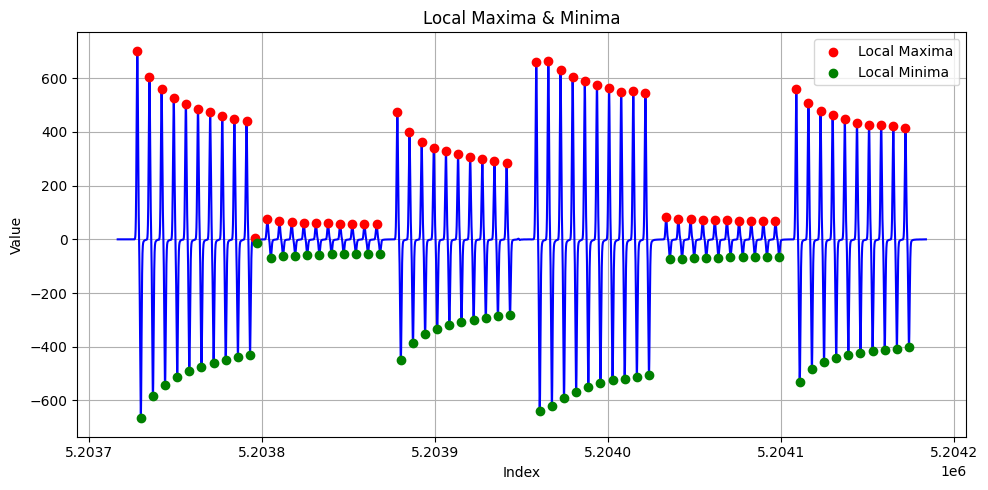

Number of valid pulses: 60/61
Example of pulse number 41:


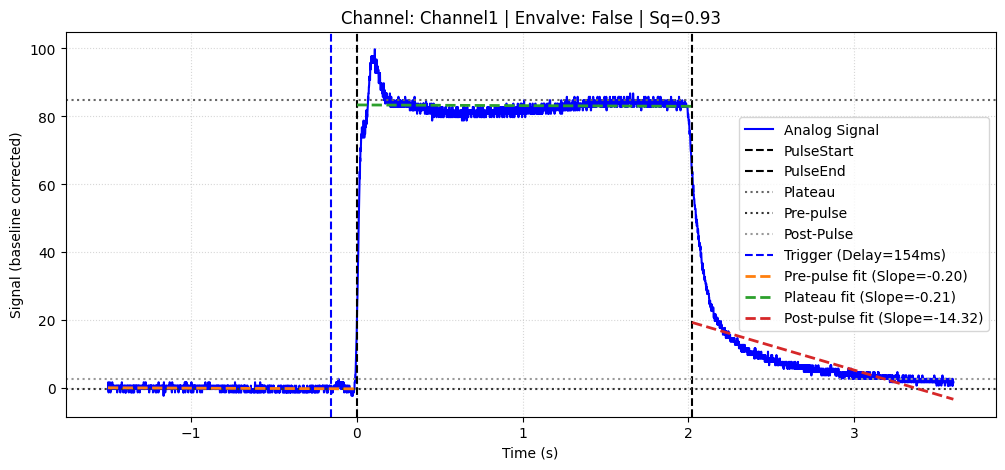

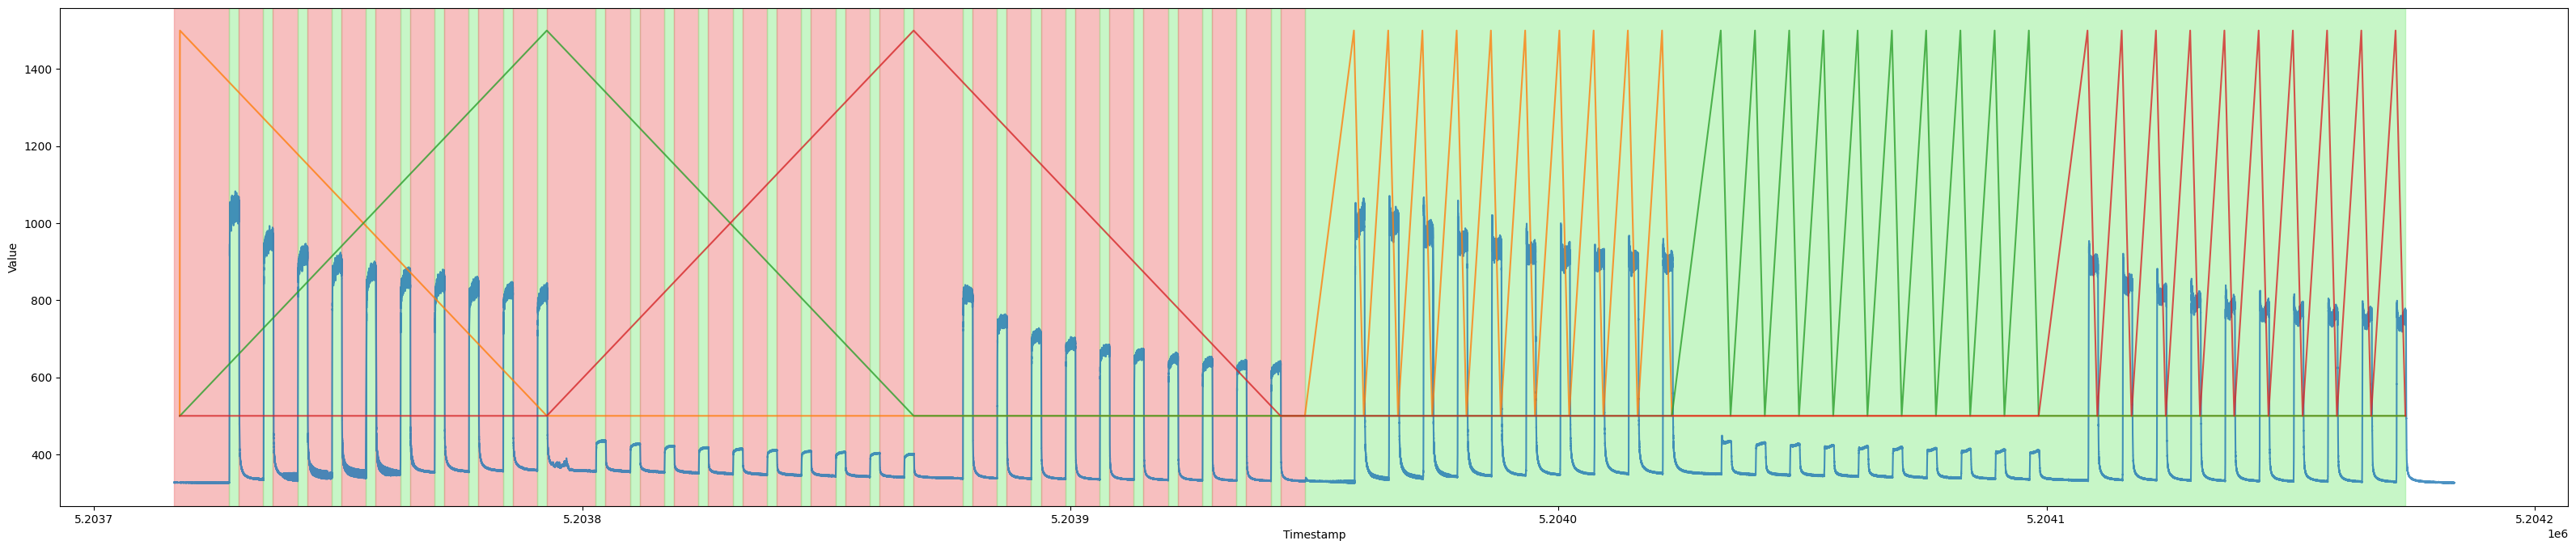

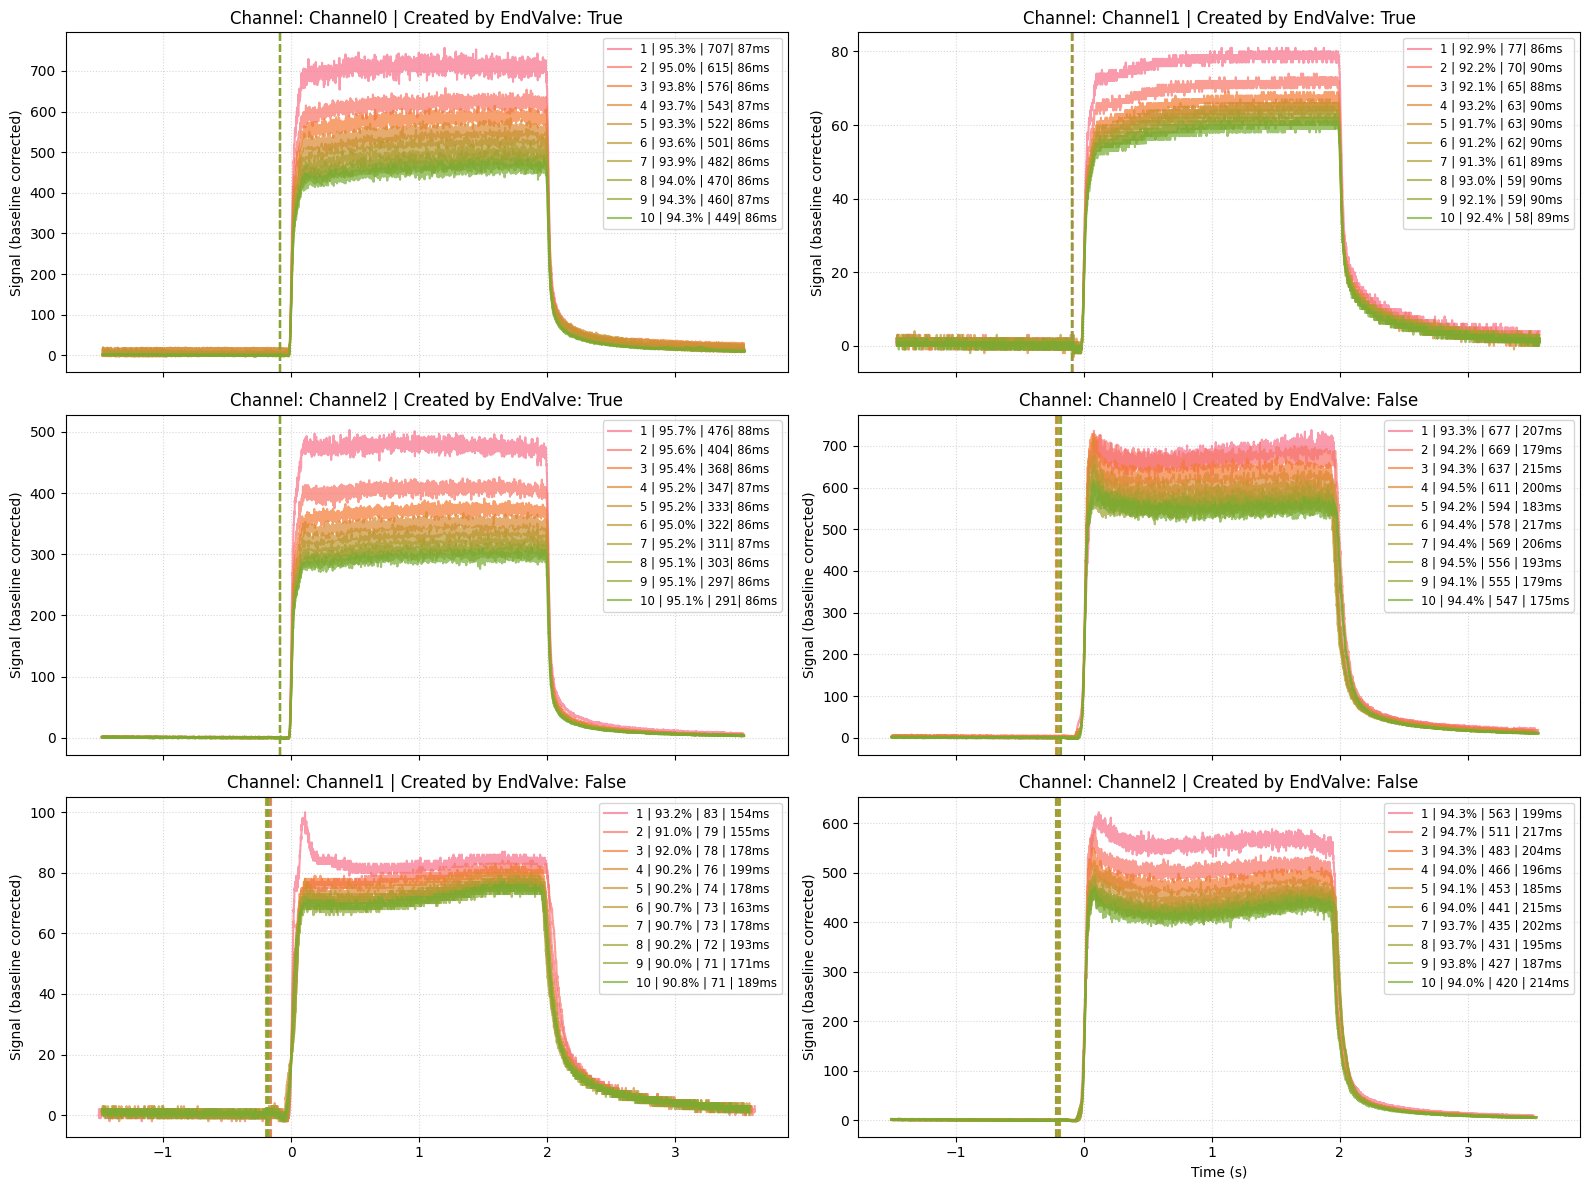

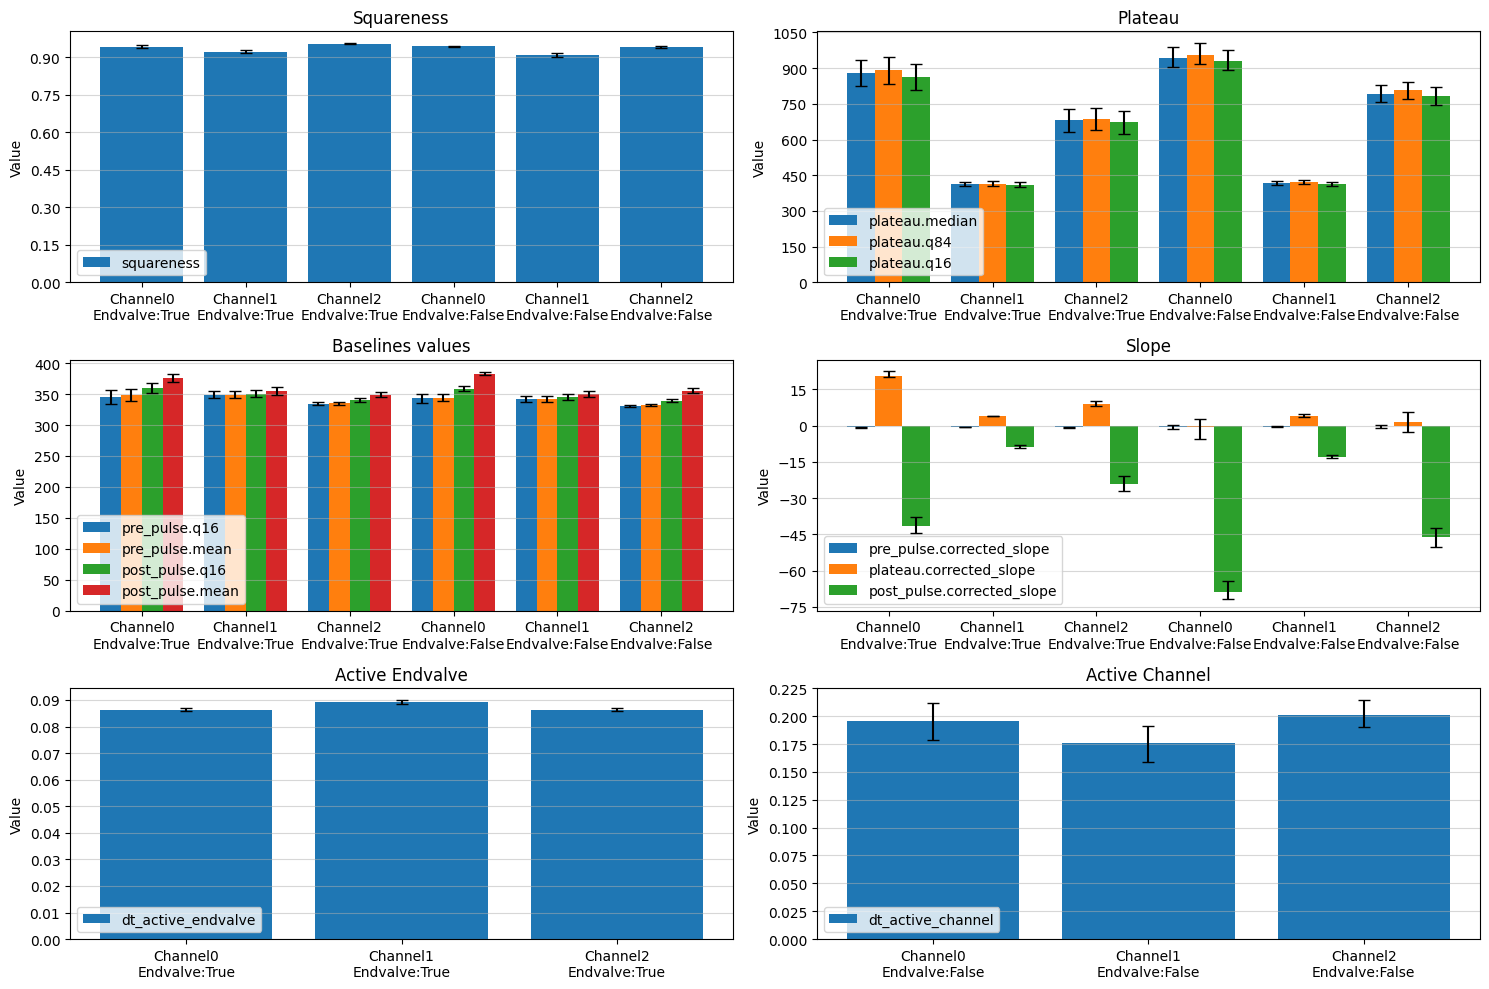

In [24]:
### RUNS ANALYSIS IN A SINGLE FOLDER###
verbose = True
base_path = "C:/Data/Olfact/olfactometer-4C/olfactometer_4C_2025-11-12T051921Z"

registers, groups_of_pulses = run_complete_analysis(base_path)

if verbose: 
    draw_general_graph(registers)
    draw_groups_of_pulses(groups_of_pulses)

        
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))  # 3 rows, 2 cols
    axes = axes.flatten()  # make it easy to index

    plot_combined_group_dashboard(axes[0], groups_of_pulses, ['squareness'],title="Squareness")
    plot_combined_group_dashboard(axes[1], groups_of_pulses, ['plateau.median', 'plateau.q84', 'plateau.q16'],title="Plateau")
    plot_combined_group_dashboard(axes[2], groups_of_pulses, ['pre_pulse.q16',  'pre_pulse.mean','post_pulse.q16', 'post_pulse.mean'], title="Baselines values")
    plot_combined_group_dashboard(axes[3], groups_of_pulses, ['pre_pulse.corrected_slope', 'plateau.corrected_slope','post_pulse.corrected_slope'], title="Slope")
    plot_combined_group_dashboard(axes[4], groups_of_pulses, ['dt_active_endvalve'],
                            ['Channel0-Endvalve:True', 'Channel1-Endvalve:True', 'Channel2-Endvalve:True'],
                            title="Active Endvalve")
    plot_combined_group_dashboard(axes[5], groups_of_pulses, ['dt_active_channel'],
                            ['Channel0-Endvalve:False', 'Channel1-Endvalve:False', 'Channel2-Endvalve:False'],
                            title="Active Channel")
    plt.tight_layout()
    plt.show()
